In [1]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import sys, re, os, path
from matplotlib import axis

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')
from scripts.preProcess import readPatchData
from scripts.preProcess import readCellCenters
from scripts.preProcess import readVectorData

In [2]:
import contextlib
import io
import sys

class NoStdStreams(object):
    def __init__(self,stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

In [3]:
path = '/home/leonriccius/Desktop/PeriodicHills/mesh_convergence_nx_ny_refined/Re10595/'
folders = sorted([folder for folder in os.listdir(path) if os.path.isdir(os.sep.join([path, folder]))], reverse=False)

# file = 'wallShearStress'
# fileName = os.sep.join([path, file])
# patch = 'bottomWall'
# shearStress = readPatchData(os.sep.join([path, 'wallShearStress']), patch)
# cellCenters = readPatchData(os.sep.join([path, 'cellCenters']), patch)

In [4]:
interval = {'PH10595': [[1,7], [-0.0005, 0.002]]}
case = 'PH10595'
len(folders)

17

Text(0, 0.5, '$\\tau_w$')

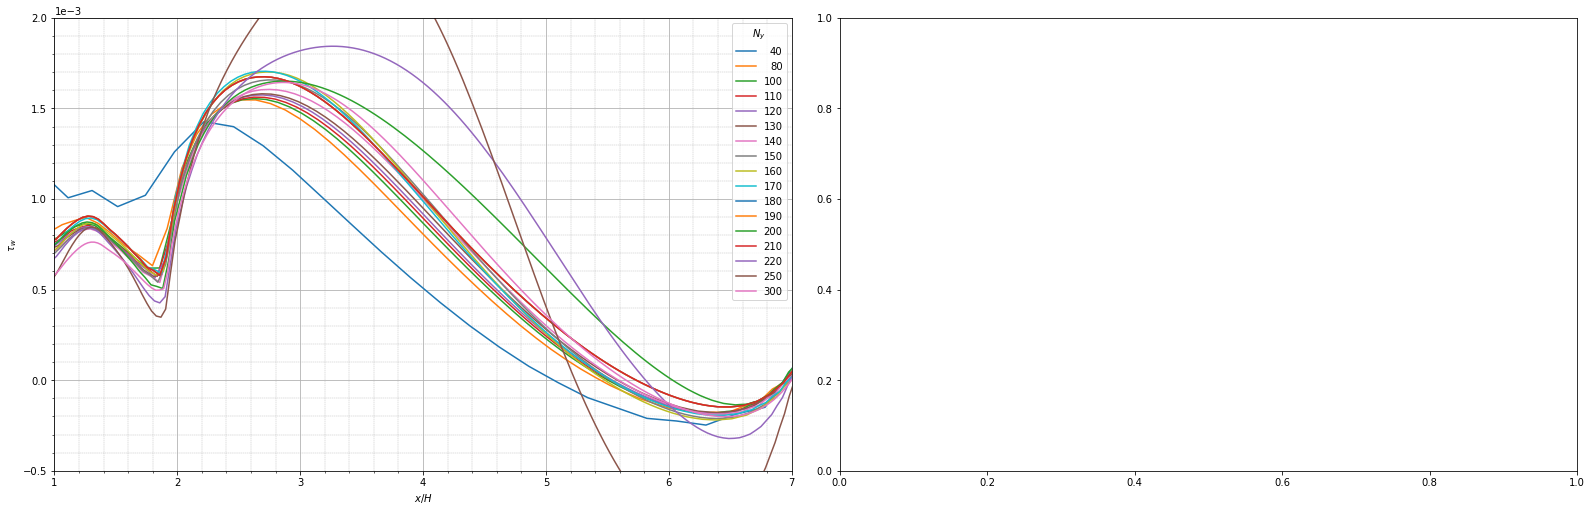

In [5]:
# initialize variables to store data
refinement_level = []
shearStress_list = [None]*len(folders)
cellCenters_list = [None]*len(folders)

# create figure
nrows = 1
ncols = 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5.5*ncols, 3.5*nrows), constrained_layout=True)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (2*5.5*ncols, 2*3.5*nrows), constrained_layout=True)

for f, folder in enumerate(folders):
    
    # set current folder
    curr_dir = os.sep.join([path, folder])
    index=folder.rfind('_')
    refinement_level.append(str(int(folder[index+1:])))
    
    # find latest time step
    rans_time = max([entry for entry in os.listdir(curr_dir) if entry.isnumeric()])
    
    #read in data
    patch = 'bottomWall'
    with NoStdStreams():
        shearStress = readPatchData(os.sep.join([curr_dir, rans_time, 'wallShearStress']), patch)
        cellCenters = readPatchData(os.sep.join([curr_dir, rans_time, 'cellCenters']), patch)
#         U = readVectorData(rans_time, 'U', curr_dir)
#         cellCenters_internal = readCellCenters(rans_time, curr_dir)
    # initialize variables
    tangent = th.zeros_like(cellCenters)
    length = cellCenters.shape[0]

    # compute tangents via central differences except for endpoints
    for i in range(length):
        if i == 0:
            tangent[0,:] = cellCenters[i+1] - cellCenters[i]
        elif i==length-1:
            tangent[i,:] = cellCenters[i] - cellCenters[i-1]
        else:
            tangent[i,:] = cellCenters[i+1] - cellCenters[i-1]

    # normalize tangents
    tangent = tangent/th.norm(tangent, dim=1).unsqueeze(1)
    normal = tangent[:,[1,0,2]]
    normal[:,0] = -normal[:,0]

    # project shear stress onto tangent vector
    shearStressTangential = th.einsum('ij,ij->i', tangent, shearStress)
    shearStressNormal = th.einsum('ij,ij->i', normal, shearStress)
    
    # store shear stresses and cellCenters
    shearStress_list[f] = shearStressTangential
    cellCenters_list[f] = cellCenters
    
    # plot shear stress and set region to plot
    ax[0].plot(cellCenters[:,0], shearStressTangential)
    ax[0].set_xlim(interval[case][0])
    ax[0].set_ylim(interval[case][1])
#     ax.set_ylim([-0.0005, 0.004])

# format ticks
ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# set minor ticks
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax[0].grid(which='major')
ax[0].grid(which='minor', linestyle='--', linewidth=0.4)

# set legend and align right
renderer = fig.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in ax[0].legend(refinement_level).get_texts()])
for t in ax[0].legend(refinement_level, title=r'$N_y$').get_texts():
    t.set_ha('right')
    t.set_position((shift,0))
    
# set labels
ax[0].set_xlabel(r'$x/H$')
ax[0].set_ylabel(r'$\tau_w$')


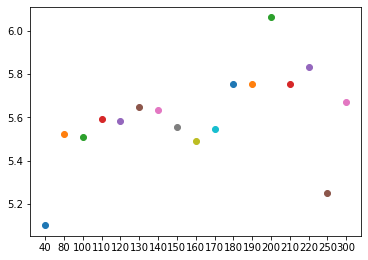

In [6]:
# create figure
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5*ncols, 3.5*nrows), constrained_layout=True)

for i in range(len(shearStress_list)):
    shearStress = shearStress_list[i]
    cellCenters = cellCenters_list[i]

    index = np.argmax((shearStress<0)*(cellCenters[:,0]>4.))
    ax.scatter(refinement_level[i], cellCenters[index,0])

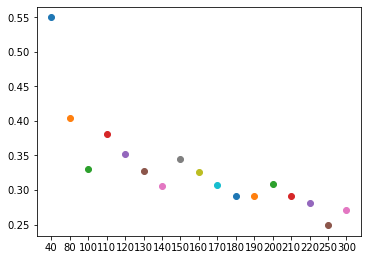

In [7]:
# create figure
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5*ncols, 3.5*nrows), constrained_layout=True)

for i in range(len(shearStress_list)):
    shearStress = shearStress_list[i]
    cellCenters = cellCenters_list[i]

    index = np.argmax((shearStress>0)*(cellCenters[:,0]<4.))
    ax.scatter(refinement_level[i], cellCenters[index,0])

(0.0, 2.0)

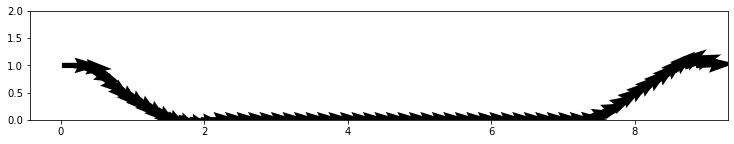

In [8]:
fig, ax = plt.subplots(figsize = (12.5, 2))
ax.quiver(cellCenters[::5,0], cellCenters[::5,1], tangent[::5,0], tangent[::5,1])
ax.set_ylim([0,2])

NameError: name 'norm_1' is not defined

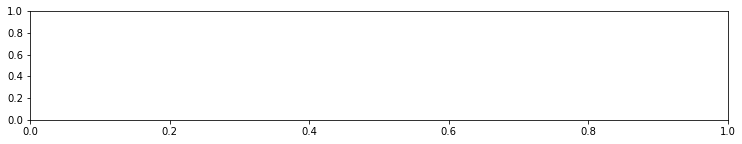

In [9]:
fig, ax = plt.subplots(figsize = (12.5, 2))
ax.quiver(cellCenters[::5,0], cellCenters[::5,1], norm_1[::5], norm_2[::5])
ax.set_ylim([0,2])

In [ ]:
fig, ax = plt.subplots()
ax.plot(cellCenters[:,0], shearStress[:,1])
ax.set_xlim([5,8])
ax.set_ylim([-0.0006, 0.001])

In [ ]:
grad_k = th.tensor([[1,2,3], [2,4,6]],dtype=th.double)
I = th.eye(3, dtype=th.double).unsqueeze(0).expand(2,3,3)
ap = th.zeros(2,3,3)
# th.cross(I[:,0],grad_k)

In [ ]:
for i in range(3):
    ap[:,:,i] = -th.cross(I[:,:,i],grad_k)

In [ ]:
ap

In [ ]:
ap.matmul(ap)